<a href="https://www.kaggle.com/code/mdrejwanurrahman/prediction-pffp?scriptVersionId=195154343" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Library import and Version Printing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import sklearn
import joblib

In [1]:
pip install scikit-learn==1.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 69.7 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.

In [3]:

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)
print('scikit-learn version:', sklearn.__version__)
print('joblib version:', joblib.__version__)


TensorFlow version: 2.16.1
TensorFlow Probability version: 0.24.0
scikit-learn version: 1.5.1
joblib version: 1.4.2


## Data Loading
The following cell loads the dataset from a text file containing measurements of depth versus deceleration. Ideally the dataset should contain deceleration, depth and velocity values of one PFFP deployment. A typical format that the auther use looks like the figure given below. 
We use this data to analyze the deceleration profile at different depths. Some example data is already provided in this repository. 

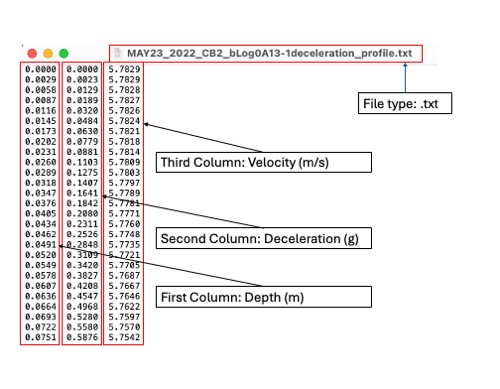


In [4]:
# Choose the filename of the uploaded file
filename = '/kaggle/input/example-data/AUG21_2023_BD131_bLog05E4-4deceleration_profile.txt'
# Load the text file containing depth vs. deceleration values
data = np.loadtxt(filename)
depth = data[:, 0]
deceleration = data[:, 1]
velocity = data[:, 2]

## Data Interpolation
Now, we will interpolate the deceleration values at exactly 1 cm interval. This will reduce the input parameters. 

In [5]:
# Create an interpolation function
interpolation_function = interp1d(depth, deceleration, kind='nearest')

# Define the depth intervals at 0.01 m increments
depth_interpolated = np.arange(min(depth), max(depth), 0.01)

# Use the interpolation function to get deceleration values at these intervals
deceleration_interpolated = interpolation_function(depth_interpolated)



## Array Padding
To prepare the data for further analysis or model input, we adjust the shape of the interpolated array to a specific shape by padding it with zeros. 
This ensures uniformity in data structure across different datasets or model requirements. 

In [6]:

# Define the desired shape (211,)
desired_shape = (211,)

# Calculate the number of zeros needed to pad
zeros_to_add = desired_shape[0] - deceleration_interpolated.shape[0]

# Pad the original array with zeros to achieve the desired shape
padded_array = np.pad(deceleration_interpolated, (0, zeros_to_add), 'constant')
padded_array=padded_array.reshape(1,211)

## Scalling inputs
To feed the deceleration values into the Bayesian Neural Network model, it needs to be scaled exactly like the training phase of the model. A scalling function was saved during the training which will be used here to scale the input. 

In [7]:
scaler = joblib.load('/kaggle/input/scaling/scikitlearn/default/1/scaler_fit.joblib') # Load the saved scaling function
padded_array=padded_array*100/velocity[0] # deceleration is divided by impact velocity and 100 is multiplied for numerical stability
pred_in_scaled = scaler.transform(padded_array.reshape(-1, 1)).reshape(padded_array.shape)
pred_in_scaled = np.reshape(pred_in_scaled,[pred_in_scaled.shape[0],pred_in_scaled.shape[1],1]) # Final prediction input after reshaping



## Model Loading and Prediction
This section demonstrates how to load a pre-trained machine learning model and use it for making predictions. 
First we will load the Random Forest model, prepare the input data by scaling and transformation, and then predict probabilities for different classes. This will be designated as prior probabilities. 


In [8]:

# Load the saved model
loaded_rf_model = joblib.load('/kaggle/input/random-forest/scikitlearn/default/1/random_forest_model.joblib')

# Now 'loaded_rf_model' contains the Random Forest model, and you can use it for predictions.
max_dec = np.max(pred_in_scaled, axis=1) # Extracting maximum deceleration
pd = np.count_nonzero(pred_in_scaled, axis=1) # Extracting penetration depth
predRF=np.column_stack((max_dec,pd)) # Making an array with both input parameters
class_probs = loaded_rf_model.predict_proba(predRF) # Obtaining the prior probabilities only using maximum deceleration and penetration depth

Next, we will scale the prior probabilities to eliminate extreme values. We will scale it in suc a way so that the sum of four class probabilities become 0.6

In [9]:
# Original array with 4 values that sum up to 1
original_array = np.array(class_probs)

# Calculate the sum of the original array
original_sum = np.sum(original_array)

# Scale the array to sum up to 0.6
desired_sum = 0.6
pad=0.1
scaled_array = (original_array / original_sum) * desired_sum
prior=scaled_array+pad
print(prior)



[[0.16  0.514 0.196 0.13 ]]


## Define Model Architecture
The model architecture needs to be defined again. This needs to be exactly same as the training phase

In [10]:
number_of_training_data = 909.0

# Define the kernel divergence function
def kernel_divergence_fn(q, p, _):
    return tfp.distributions.kl_divergence(q, p) / number_of_training_data

# Model building
class BayesianConv1DModel(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.conv1 = tfp.layers.Convolution1DFlipout(32, kernel_size=3, activation='relu', 
                                                     kernel_divergence_fn=kernel_divergence_fn, 
                                                     padding='VALID')
        self.conv2 = tfp.layers.Convolution1DFlipout(64, kernel_size=3, activation='relu', 
                                                     kernel_divergence_fn=kernel_divergence_fn, 
                                                     padding='VALID')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tfp.layers.DenseFlipout(1024, activation='relu', kernel_divergence_fn=kernel_divergence_fn)
        self.dense2 = tfp.layers.DenseFlipout(64, activation='relu', kernel_divergence_fn=kernel_divergence_fn)
        self.dense3 = tfp.layers.DenseFlipout(4, activation='softmax', kernel_divergence_fn=kernel_divergence_fn)

    def __call__(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Instantiate the model
model = BayesianConv1DModel()

# Define loss function
def loss_fn(labels, predictions):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, predictions))

# Define the training step
def train_step(model, inputs, labels, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


## Define Prediction Function
A prediction function needs to be created to predict the class probabilities.

In [11]:
import numpy as np

# Function to predict new data
def predict(model, new_data):
    """
    Generates predictions from the model for the given new data.

    Args:
    model: The trained Bayesian neural network model.
    new_data: A NumPy array or a TensorFlow tensor of new data to predict.

    Returns:
    A NumPy array of predictions.
    """
    # Ensure the input is a TensorFlow tensor
    new_data = tf.convert_to_tensor(new_data, dtype=tf.float32)

    # Perform a forward pass and obtain the logits
    logits = model(new_data)

    # Since the last layer uses softmax, the output will be the probabilities
    probabilities = tf.nn.softmax(logits)

    return probabilities.numpy()  # Convert probabilities to NumPy array for easier handling



## Restoring Weights
The weights of the trained neural network was saved after training. Those saved weights will be restored here

In [12]:
modelcp = BayesianConv1DModel()

checkpoint2 = tf.train.Checkpoint(model=modelcp)

checkpoint2.restore('/kaggle/input/bnn/tensorflow2/default/1/newcheckpoints-1')


## Likelihood Prediction
Now we will do the prediction using the Bayesian Neural Network. We will call this as likelihood probabilities. 

In [13]:

likelihood = predict(modelcp, pred_in_scaled)
class_likelihood = tf.argmax(likelihood, axis=1)
print(likelihood)
print(class_likelihood)

/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


[[0.18444706 0.21031295 0.4177205  0.18751943]]
tf.Tensor([2], shape=(1,), dtype=int64)


## Final Prediction
Since we now have prior and likelihood probabilities, we will multiply them and obtain the final probabilities. 

In [14]:
Final_Prediction=likelihood*prior/np.sum(likelihood*prior)
print(Final_Prediction)

[[0.12101678 0.44328495 0.3357343  0.09996397]]


The prior prediction model (random forest) will always provide the same results if the input parameters are same. But since the likelihood model (Bayesian Neural Network) is a dynamic model, it will yield different probabilities for the same inputs each time. By running this model multiple times we can create a box plot which can be useful for uncertainty estimation. In the code chunk below, the likelihood model has been run 30 times and the resulting final prediction is plotted. 

<Figure size 1500x600 with 0 Axes>

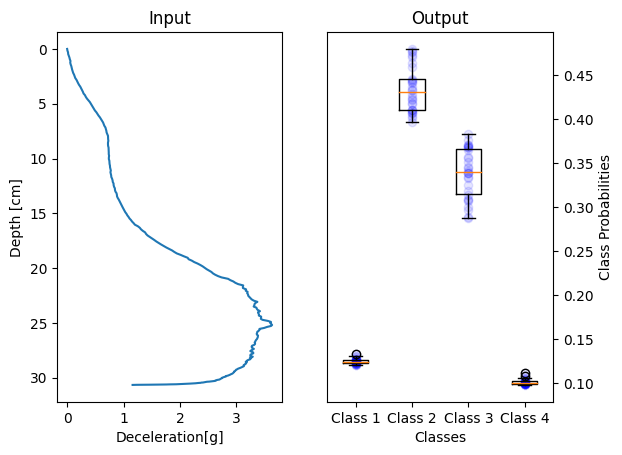

In [16]:
ss =[]
classes = ['Class 1','Class 2','Class 3','Class 4']
c = [1,2,3,4]
plt.figure(figsize=(15,6))
fig, ax = plt.subplots(1,2)

for i in range(0,30):
  s = predict(modelcp, pred_in_scaled)
  post=((prior)*s)
  final_s = post/np.sum(post)
  ss.append(final_s)
  ax[1].scatter(c,final_s,c="blue",alpha=0.1)

sss = np.squeeze(ss)
ax[1].boxplot(sss)
ax[1].set_xticklabels(classes)
ax[1].set_ylabel("Class Probabilities")
ax[1].set_xlabel("Classes")
# Move y-ticks and y-label to the right side
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()

ax[0].plot(deceleration,depth*100, label=filename)
ax[0].invert_yaxis()
ax[0].set_ylabel("Depth [cm]")
ax[0].set_xlabel("Deceleration[g]")
ax[0].set_title("Input")
ax[1].set_title("Output")

plt.show()